### Setup

In [ ]:
# Import packages needed stamp_viewer env
import numpy as np
import pandas as pd
import pickle
import os
os.environ["H5PY_DEFAULT_READONLY"] = "1" # Surpress h5py deprecation warnings
import socket
from datetime import datetime
from seticore import viewer # If you don't have it, use pip install "git+https://github.com/MydonSolutions/seticore#egg=seticore&subdirectory=python"
import matplotlib.pyplot as plt
import setigen as stg
from astropy import units as u

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /home/nstiegle


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
# Define where the data is
first_stamp_file = "/mnt/cosmic-storage-2/data1/vla_target/23A-362.sb43789194.eb44583327.60212.544836180554/23A-362.sb43789194.eb44583327.60212.544836180554.9.1/" + "23A-362.sb43789194.eb44583327.60212.544836180554.9.1.AC.C704.0000.raw.seticore.0000.stamps"

In [4]:
stamps = [stamp for stamp in viewer.read_stamps(first_stamp_file, find_recipe=True)]

In [5]:
stamp = stamps[28]

best beam is 0
original power: 6.064391e+11
original SNR: 8.271747589111328


recalculated power: 6.078966e+11
local SNR: 7.224965785931368


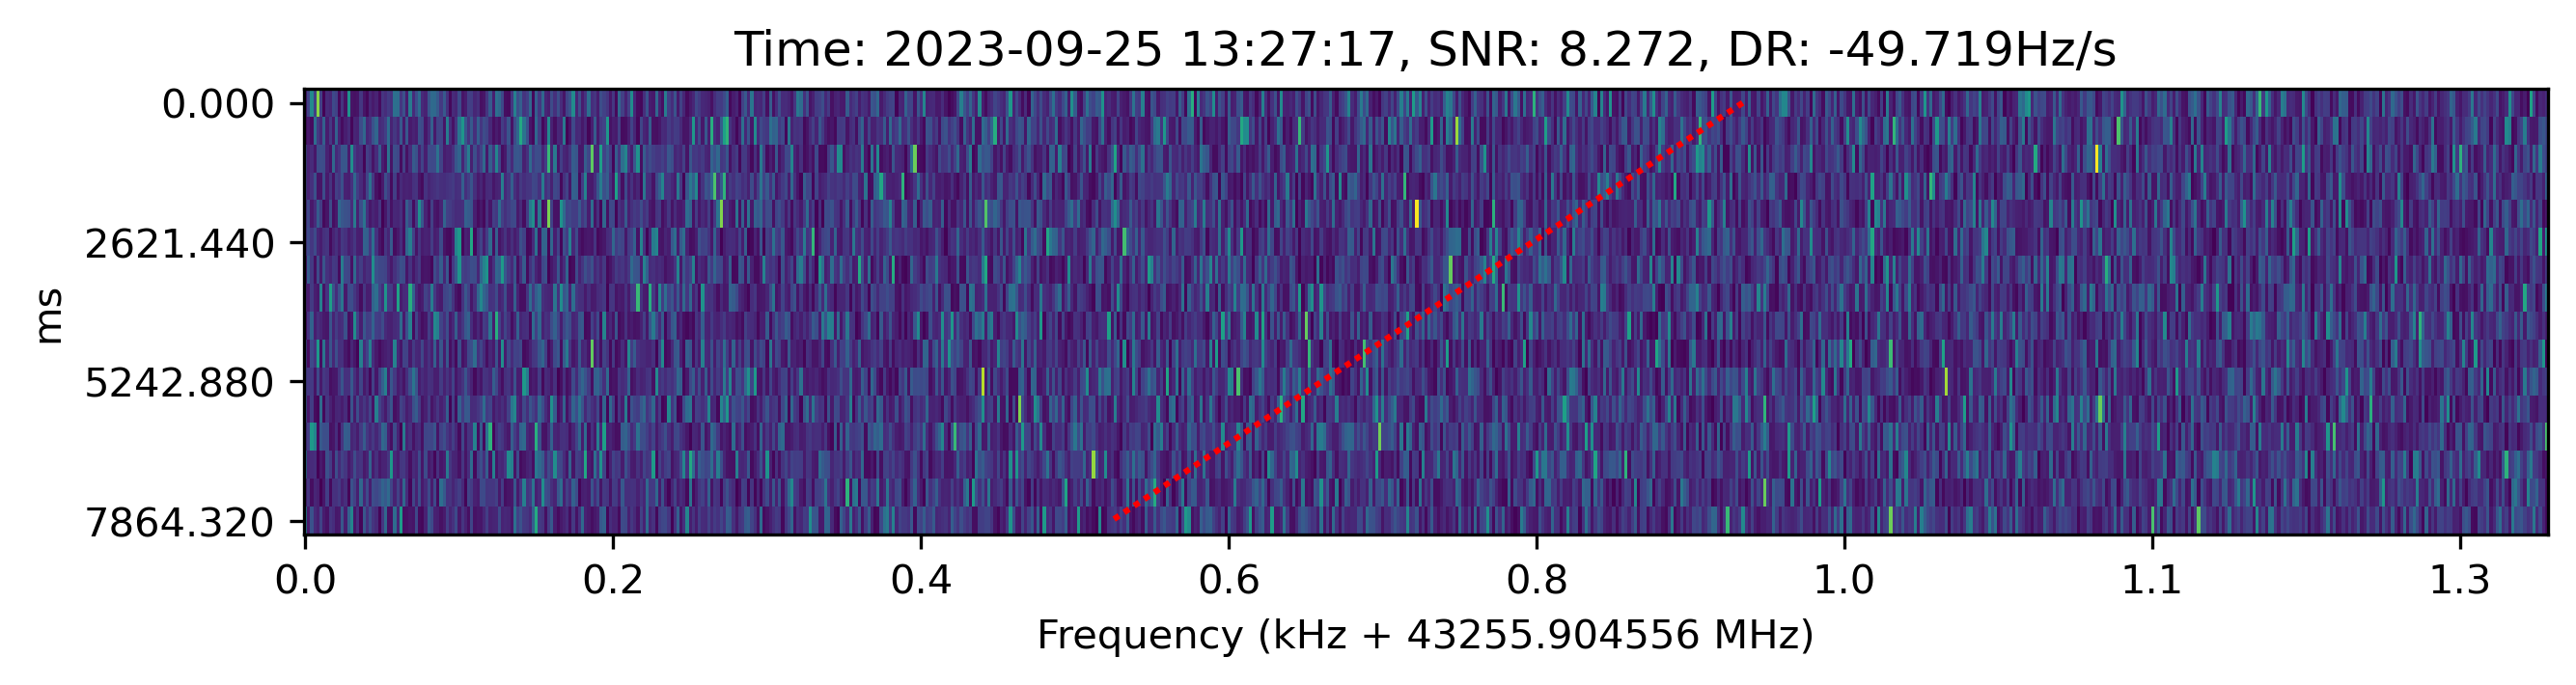

In [6]:
stamp.show_best_beam(show_signal=True, title=f"Time: {datetime.fromtimestamp(int(stamp.stamp.tstart))}, " +  
                                             f"SNR: {round(stamp.stamp.signal.snr, 3)}, " + 
                                             f"DR: {round(stamp.stamp.signal.driftRate, 3)}Hz/s")

In [8]:
print(stamp.stamp.foff)
print(stamp.stamp.tsamp)
print(stamp.stamp.fch1)


1.9073486328125e-06
0.524288
43255.90455616229


In [9]:
powers = stamp.beamform_power(0)
frame = stg.Frame.from_data(stamp.stamp.foff * u.MHz, stamp.stamp.tsamp * u.s, stamp.stamp.fch1 * u.MHz, True, powers)

In [11]:
print(powers.shape)

(16, 729)


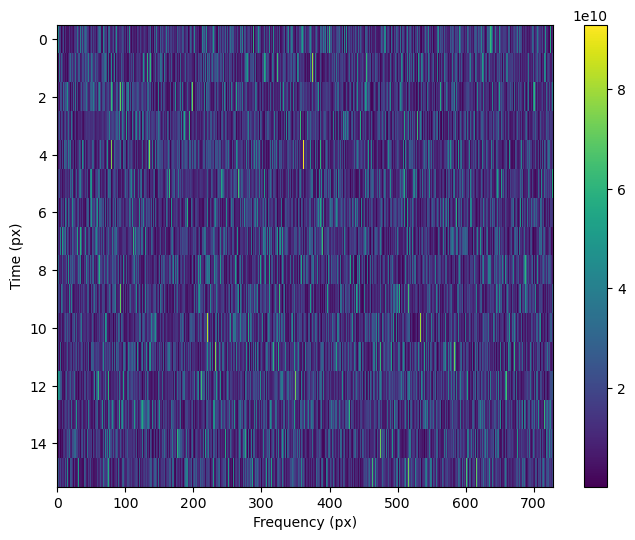

In [30]:
dedrifted = stg.dedrift(frame, 0)
fig = plt.figure(figsize=(8, 6))
stg.plot(dedrifted)
plt.show()

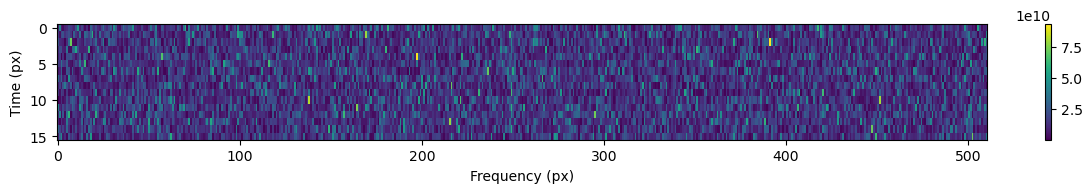

In [8]:
dedrifted = stg.dedrift(frame, stamp.stamp.signal.driftRate)
fig = plt.figure(figsize=(15, 1.5))
stg.plot(dedrifted)
plt.show()

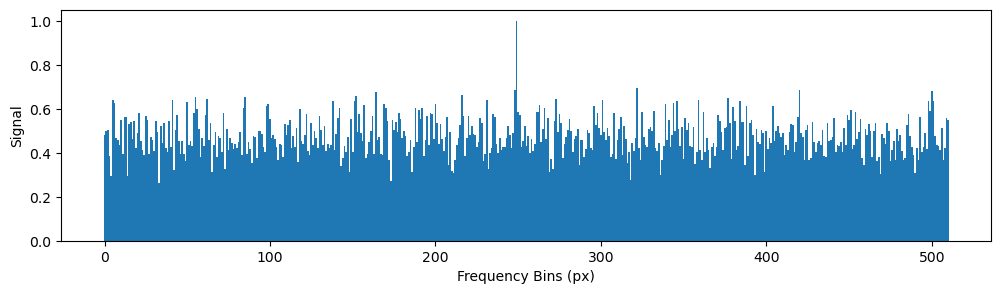

In [28]:
integrated = stg.integrate(dedrifted, mode='sum')
fig = plt.figure(figsize=(12, 3))
plt.xlabel("Frequency Bins (px)")
plt.ylabel("Signal")
plt.bar(range(len(integrated)), integrated / max(integrated), width=1)
plt.show()

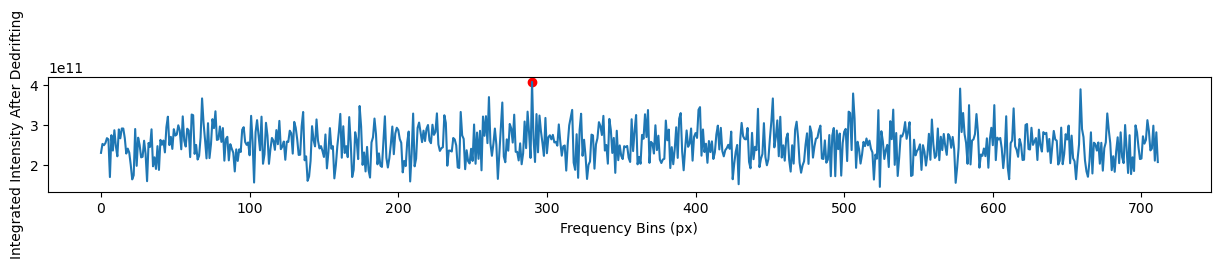

In [10]:
# drift_rate = stamp.stamp.signal.driftRate
drift_rate = 4
test_integrated = stg.integrate(stg.dedrift(frame, drift_rate), mode='sum')
fig = plt.figure(figsize=(15, 1.5))
plt.xlabel("Frequency Bins (px)")
plt.ylabel("Integrated Intensity After Dedrifting")
plt.plot(test_integrated)
plt.scatter(np.argmax(test_integrated), max(test_integrated), marker='o', color='red')
plt.show()


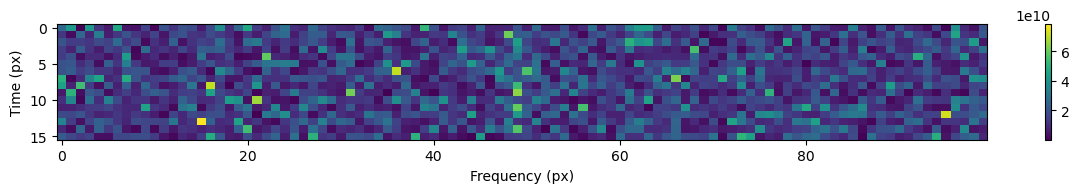

In [11]:
fig = plt.figure(figsize=(15, 1.5))
stg.get_slice(dedrifted, 200, 300).plot()

In [12]:
def give_snr_of_max(integrated):
    median = np.percentile(integrated, 50)
    top_5 = np.percentile(integrated, 95)
    bottom_5 = np.percentile(integrated, 5)
    center_data = integrated[(integrated < top_5) * (integrated > bottom_5)]
    std_dev = center_data.std()

    return (max(integrated) - median) / std_dev

In [13]:
# Look at how that peak changes with drift rate
maxes = []
medians = []
snr_of_maxes = []
drift_rates_to_try = np.arange(-50, 50, .125)
for i, dr in enumerate(drift_rates_to_try):
    test_dedrifted = stg.dedrift(frame, dr)
    test_integrated = stg.integrate(test_dedrifted, mode='sum')
    peak = max(test_integrated)
    maxes.append(peak)
    median = np.median(test_integrated)
    medians.append(median)
    snr_of_max = give_snr_of_max(test_integrated)
    snr_of_maxes.append(snr_of_max)

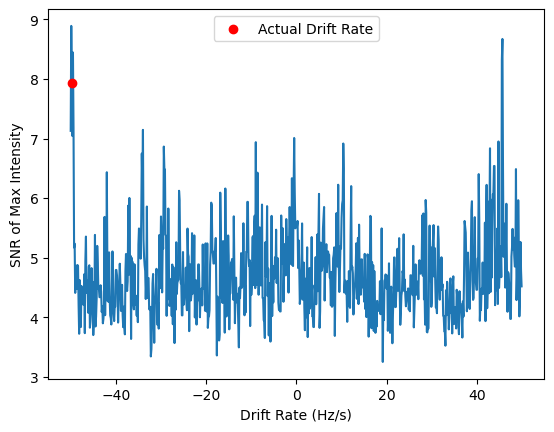

In [14]:
plt.plot(drift_rates_to_try, snr_of_maxes)
plt.scatter(stamp.stamp.signal.driftRate, give_snr_of_max(integrated), marker='o', color='red', label="Actual Drift Rate", zorder=100)
plt.xlabel("Drift Rate (Hz/s)")
plt.ylabel("SNR of Max Intensity")
plt.legend()
plt.show()

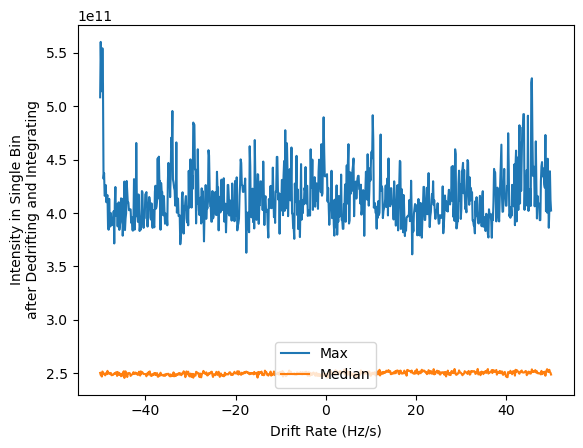

In [15]:
plt.plot(drift_rates_to_try, maxes, label='Max')
plt.plot(drift_rates_to_try, medians, label="Median")
plt.xlabel("Drift Rate (Hz/s)")
plt.ylabel("Intensity in Single Bin\nafter Dedrifting and Integrating")
plt.legend(loc='lower center')
plt.show()

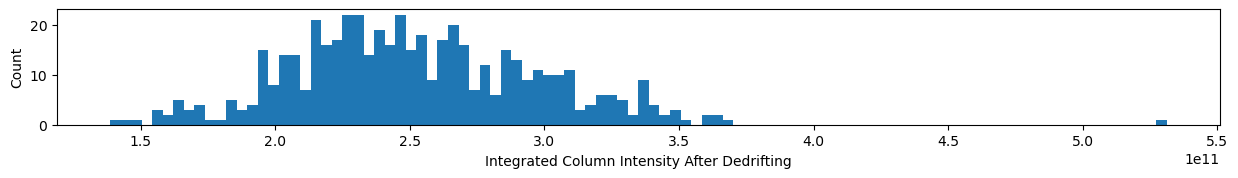

In [16]:
fig = plt.figure(figsize=(15, 1.5))
counts, bin_edges, patches = plt.hist(integrated, bins=100)
plt.xlabel("Integrated Column Intensity After Dedrifting")
plt.ylabel("Count")
plt.show()

In [17]:
# Compute Statistics
median = np.percentile(integrated, 50)
top_5 = np.percentile(integrated, 95)
bottom_5 = np.percentile(integrated, 5)
center_data = integrated[(integrated < top_5) * (integrated > bottom_5)]
std_dev = center_data.std()
snr_thresh = 8

(max(integrated) - median) / std_dev

7.934928597208404

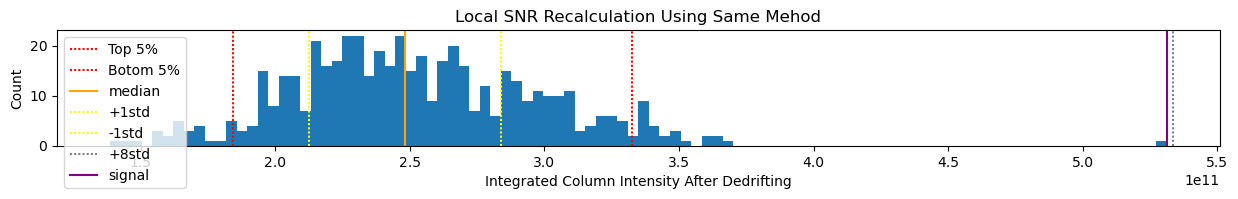

In [18]:
fig = plt.figure(figsize=(15, 1.5))
plt.hist(integrated, bins=100)
plt.axvline(top_5, dashes=[1, 1, 1, 1], color='red', label="Top 5%")
plt.axvline(bottom_5, dashes=[1, 1, 1, 1], color='red', label="Botom 5%")
plt.axvline(median, color='orange', label='median')
plt.axvline(median + std_dev, color='yellow', dashes=[1, 1, 1, 1], label='+1std')
plt.axvline(median - std_dev, color='yellow', dashes=[1, 1, 1, 1], label='-1std')
plt.axvline(median + snr_thresh * std_dev, color='grey', dashes=[1, 1, 1, 1], label=f'+{snr_thresh}std')
plt.axvline(max(integrated), color='purple', label='signal')
plt.legend(loc='upper left')
plt.title("Local SNR Recalculation Using Same Mehod")
plt.xlabel("Integrated Column Intensity After Dedrifting")
plt.ylabel("Count")
plt.show()

In [19]:
recalculated_snr = (max(integrated) - median) / std_dev
print("Reclaculated SNR:", recalculated_snr)

Reclaculated SNR: 7.934928597208404


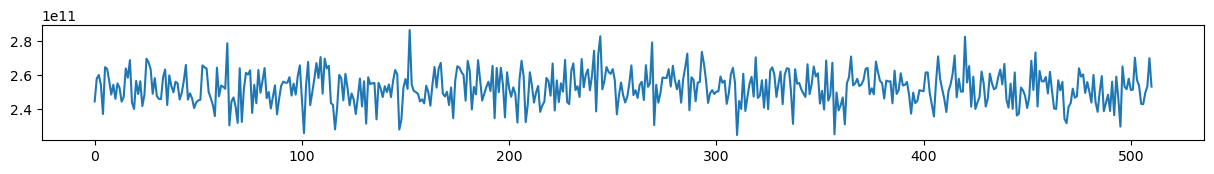

In [20]:
# Look at same with incoherent
incoherent = np.square(stamp.real_array()).sum(axis=(2, 3, 4))
incoherent_frame = stg.Frame.from_data(stamp.stamp.foff * u.MHz, stamp.stamp.tsamp * u.s, stamp.stamp.fch1 * u.MHz, True, incoherent)
incoherent_dedrifted = stg.dedrift(incoherent_frame, stamp.stamp.signal.driftRate)
incoherent_integrated = stg.integrate(incoherent_dedrifted, mode='sum')
fig = plt.figure(figsize=(15, 1.5))
plt.plot(incoherent_integrated)